In [1]:
include("slim_reader.jl")
include("Network.jl")
include("Encoder.jl")

using Knet, ImageMagick, Colors, Images, Sloth, DRAW, Random
BATCH_SIZE = 50
EPOCH = 1000
NUMBATCHES = 100
slim_data_dir = "/home/ec2-user/efs/slim-dataset"
nt_train_files = Slim_Reader.get_train_filenames(slim_data_dir, false, true)
# Construct training dataset object for synthetic data
nt_train_data = Slim_Reader.make_dataset_object(nt_train_files, BATCH_SIZE)
nt_train_batch = Slim_Reader.get_next_batch(nt_train_data, KnetArray{Float32}, false, true);
images, captions, cameras = getdata(nt_train_batch)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at slim_reader.jl:6
└ @ Core /home/ec2-user/comp492/Text2Image-cemil-slim-dataset-reader/slim_reader.jl:6
┌ Info: Recompiling stale cache file /home/ec2-user/.julia/compiled/v1.2/DRAW/AGNCk.ji for DRAW [7e16b5a0-e062-11e9-3467-b7e39d9ee233]
└ @ Base loading.jl:1240
┌ Warning: Package DRAW does not have Sloth in its dependencies:
│ - If you have DRAW checked out for development and have
│   added Sloth as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DRAW
└ Loading Sloth into DRAW from project dependency, future warnings for DRAW are suppressed.





Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.



2019-12-22 09:42:32.047520: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2019-12-22 09:42:32.070013: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300070000 Hz
2019-12-22 09:42:32.070444: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x40aad60 executing computations on platform Host. Devices:
2019-12-22 09:42:32.070466: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: K

(K32(50,10,128,128,3)[0.6039216⋯], ["a green cone is only an eight visible out of frame to the left. a blue disc is half visible to the right out of frame and a larger green triangle is half visible out of frame to the right in the background" "A bright lime green triangle next to a very tiny dark blue.purple circle figure and then towards the edge on the right side is a yellow cylinder figure." … "A light yellow cone is in front of and to the right of the small purple cylinder and the green taller triangle. The small purple cylinder is directly in front of the green triangle." "In this room there is a gray wall, a larger gray floor, and a blue sky. The room is mostly open, but on the far left side about halfway to the wall is half a green cone. On the right side there a small part of a blue rectangle laying on the ground which is covering the bottom part of a larger green triangle. Only one corner of the triangle is visible."; "The ceiling is a light blue color. The walls are a medium

In [2]:
captions

50×10 Array{String,2}:
 "a green cone is only an eight visible out of frame to the left. a blue disc is half visible to the right out of frame and a larger green triangle is half visible out of frame to the right in the background"                                                                                                                                                                                                                                               …  "In this room there is a gray wall, a larger gray floor, and a blue sky. The room is mostly open, but on the far left side about halfway to the wall is half a green cone. On the right side there a small part of a blue rectangle laying on the ground which is covering the bottom part of a larger green triangle. Only one corner of the triangle is visible."                                               
 "The ceiling is a light blue color. The walls are a medium gray with rectangular shapes vaguely seen. In the middle of the 

In [3]:
goldimages = creategoldimg(images)

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.607843
 0.615686  0.619608  0.615686  0.615686     0.611765  0.623529  0.631373
 0.666667  0.678431  0.682353  0.709804     0.643137  0.67451   0.678431
 0.780392  0.756863  0.803922  0.8       …  0.682353  0.380392  0.298039
 0.796078  0.811765  0.8       0.784314     0.701961  0.282353  0.317647
 0.807843  0.803922  0.803922  0.784314     0.701961  0.298039  0.282353
 ⋮ 

In [4]:
n = Network()

Network(RepresentationModel(CaptionEncoder(ConvModel(P(KnetArray{Float32,4}(1,30,64,32)), P(KnetArray{Float32,4}(1,2,32,1)), NNlib.relu), Corpus(Dict("" => 1), P(KnetArray{Float32,2}(64,1)))), AngleEncoder(MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(32,2)), P(KnetArray{Float32,2}(32,500))),))), MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(128,96)), P(KnetArray{Float32,2}(128,500))), Layer0(P(KnetArray{Float32,2}(196,128)), P(KnetArray{Float32,2}(196,500))), Layer0(P(KnetArray{Float32,2}(256,196)), P(KnetArray{Float32,2}(256,500)))))), GenerationModel(ImageEncoder(Layer0(P(KnetArray{Float32,2}(1024,288)), P(KnetArray{Float32,2}(1024,50))), ImageConvModel(P(KnetArray{Float32,4}(17,17,4,1)), P(KnetArray{Float32,4}(16,16,1,1)), NNlib.relu), SamplingModel(Layer0(P(KnetArray{Float32,2}(162,256)), P(KnetArray{Float32,2}(162,50))), Layer0(P(KnetArray{Float32,2}(162,256)), P(KnetArray{Float32,2}(162,50))))), ImageDecoder(P(KnetArray{Float32,4}(32,32,3,450)), P(KnetArray{Float32,4

In [5]:
function loss(n::Network, images, captions, cameras, final_output_gold)
    output = n(images, captions, cameras)
    recon = bce(output.rimages, final_output_gold) #*32 *32 # neden 32*32 ile carptik
    mu_2 = DRAW.square(output.mu)
    kl = 0.5 * sum(output.sigma + mu_2 .- 1 - output.logsigma)
    return recon + kl
end

loss (generic function with 1 method)

In [6]:
function update_weights!(n::Network, images, captions, cameras, y)
    J = @diff loss(n, images, captions, cameras, y)
    for par in params(n)
        g = grad(J, par)
        update!(value(par), g; lr=0.1)
    end
    return value(J)
end

update_weights! (generic function with 1 method)

In [8]:
function epoch!(n::Network, syn_train_data) # last loss = loss before last update
    loss_values = []
    for i in 1:EPOCH
        loss = 0
        for j in 1:NUMBATCHES
            syn_train_batch = Slim_Reader.get_next_batch(syn_train_data, KnetArray{Float32}, false, true)
            images, captions, cameras = getdata(syn_train_batch)
            y = creategoldimg(images)
            loss = loss + update_weights!(n, images, captions, cameras, y)
            println("I have seen batch number: ", j)
        end
        push!(loss_values, loss/NUMBATCHES)
        Knet.save(string("trained_model_nt", i, ".jld2"), "results", n)
    end
    return loss_values
end

epoch! (generic function with 1 method)

In [11]:
loss_values = epoch!(n, nt_train_data)

I have seen batch number: 1
I have seen batch number: 2
I have seen batch number: 3
I have seen batch number: 4
I have seen batch number: 5
I have seen batch number: 6
I have seen batch number: 7
I have seen batch number: 8
I have seen batch number: 9
I have seen batch number: 10
I have seen batch number: 11
I have seen batch number: 12
I have seen batch number: 13
I have seen batch number: 14
I have seen batch number: 15
I have seen batch number: 16
I have seen batch number: 17
I have seen batch number: 18
I have seen batch number: 19
I have seen batch number: 20
I have seen batch number: 21
I have seen batch number: 22
I have seen batch number: 23
I have seen batch number: 24
I have seen batch number: 25
I have seen batch number: 26
I have seen batch number: 27
I have seen batch number: 28
I have seen batch number: 29
I have seen batch number: 30
I have seen batch number: 31
I have seen batch number: 32
I have seen batch number: 33
I have seen batch number: 34
I have seen batch numbe

I have seen batch number: 84
I have seen batch number: 85
I have seen batch number: 86
I have seen batch number: 87
I have seen batch number: 88
I have seen batch number: 89
I have seen batch number: 90
I have seen batch number: 91
I have seen batch number: 92
I have seen batch number: 93
I have seen batch number: 94
I have seen batch number: 95
I have seen batch number: 96
I have seen batch number: 97
I have seen batch number: 98
I have seen batch number: 99
I have seen batch number: 100
I have seen batch number: 1
I have seen batch number: 2
I have seen batch number: 3
I have seen batch number: 4
I have seen batch number: 5
I have seen batch number: 6
I have seen batch number: 7
I have seen batch number: 8
I have seen batch number: 9
I have seen batch number: 10
I have seen batch number: 11
I have seen batch number: 12
I have seen batch number: 13
I have seen batch number: 14
I have seen batch number: 15
I have seen batch number: 16
I have seen batch number: 17
I have seen batch numb

5-element Array{Any,1}:
 2.6917433311724652
 0.6799134478282667
 0.6798717274578303
 0.6797818495023239
 0.6796647160166686

In [14]:
syn_test_files = Slim_Reader.get_test_filenames(slim_data_dir, true, false)
# Construct training dataset object for synthetic data
syn_test_data = Slim_Reader.make_dataset_object(syn_test_files, BATCH_SIZE)
syn_test_batch = Slim_Reader.get_next_batch(syn_test_data, KnetArray{Float32}, false, true);
tstimages, tstcaptions, tstcameras = getdata(syn_test_batch)
goldtstimages = creategoldimg(tstimages)

OMP: Info #250: KMP_AFFINITY: pid 6396 tid 6438 thread 2 bound to OS proc set 2


32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.603922  0.603922  0.603922  0.603922  …  0.603922   0.603922   0.603922 
 0.603922  0.603922  0.603922  0.603922     0.603922   0.603922   0.603922 
 0.603922  0.603922  0.603922  0.603922     0.603922   0.603922   0.603922 
 0.603922  0.603922  0.603922  0.603922     0.603922   0.603922   0.603922 
 0.603922  0.603922  0.603922  0.603922     0.607843   0.6        0.603922 
 0.603922  0.603922  0.603922  0.603922  …  0.596078   0.6        0.596078 
 0.603922  0.603922  0.603922  0.603922     0.603922   0.615686   0.568627 
 0.603922  0.603922  0.603922  0.603922     0.447059   0.223529   0.2      
 0.682353  0.678431  0.666667  0.666667     0.188235   0.188235   0.188235 
 0.670588  0.643137  0.607843  0.654902     0.180392   0.184314   0.184314 
 0.713726  0.760784  0.756863  0.729412  …  0.184314   0.180392   0.180392 
 0.717647  0.752941  0.756863  0.729412     0.176471   0.176471   0.172549 
 0.721569  0.686275  0.709804  0.737255 

In [36]:
function predict(n, captions, cameras)   #(n::Network, images, captions, cameras)
    r, unseen_ang = n.representationModel(captions, cameras)
    conditional_variable = vcat(r, unseen_ang)
    mu = KnetArray{Float32}(Knet.zeros(162,50))
    sigma = KnetArray{Float32}(Knet.ones(162,50))
    z = mu .+ randn!(similar(mu)) .* sigma
    decinput = reshape(vcat(z, conditional_variable), (1,1,450,50))
    rimages = n.generationModel.image_decoder(decinput)
    return rimages
end

predict (generic function with 1 method)

In [37]:
rimages = predict(n, tstcaptions, tstcameras)

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.456593  0.441817  0.446013  0.415534  …  0.0       0.448852  0.446929
 0.407802  0.44769   0.372856  0.324934     0.39746   0.350076  0.471018
 0.376664  0.318619  0.399036  0.314099     0.376676  0.401614  0.391159
 0.38611   0.0       0.296836  0.358592     0.471505  0.316036  0.375595
 0.331703  0.353581  0.359535  0.359413     0.429308  0.334278  0.443999
 0.324736  0.323934  0.386067  0.465844  …  0.419742  0.465989  0.338321
 0.444837  0.395524  0.361594  0.245676     0.0       0.329516  0.49629 
 0.437935  0.392135  0.3209    0.341015     0.332628  0.269273  0.372448
 0.566216  0.614239  0.543962  0.495274     0.507815  0.577959  0.596617
 0.324312  0.0       0.42042   0.503352     0.517374  0.434766  0.428623
 0.160957  0.316128  0.32456   0.384687  …  0.470562  0.450851  0.0     
 0.2409    0.359773  0.319408  0.406801     0.444744  0.411389  0.477869
 0.354446  0.187701  0.220969  0.297439     0.578079  0.399976  0.22348 
 ⋮ 

In [39]:
outimg = permutedims(rimages[:,:,:,40], (3,1,2))

3×32×32 KnetArray{Float32,3}:
[:, :, 1] =
 0.372798  0.459751  0.409685  0.417663  …  0.902798  0.965876  0.923985
 1.96808   1.94339   2.01077   1.92538      0.983894  1.00608   0.812394
 4.21591   3.94447   4.13423   3.93421      0.762419  0.931562  0.899066

[:, :, 2] =
 0.413674  0.433239  0.43264  0.0      …  0.821513  0.941485  1.06367 
 2.02652   1.84502   1.92251  1.81356     0.893917  0.93065   0.973211
 4.12425   3.85861   4.04007  3.67178     0.910252  0.885956  1.00484 

[:, :, 3] =
 0.45483  0.46249  0.384722  0.327488  …  0.908409  0.909918  0.942063
 1.96479  2.04401  2.044     1.97067      1.02292   1.00477   0.788686
 3.70439  3.76032  3.96106   3.99432      1.08468   1.13728   0.874155

...

[:, :, 30] =
 0.0      0.465569  0.327442  0.433454  …  1.04493   0.868678  0.917255
 2.01879  1.97571   2.08231   2.00719      0.852737  0.826268  0.98488 
 3.88865  4.17943   3.87372   3.85723      0.942049  1.10517   0.898079

[:, :, 31] =
 0.427288  0.42987  0.460643  0.481797

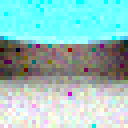

In [40]:
colorview(RGB, Array(outimg))

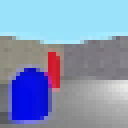

In [25]:
colorview(RGB, Array(permutedims(goldtstimages[:,:,:,10], (3,1,2))))